# Predict Future Sales (Gelecekteki Satışları Tahmin Et)

## 1. Problemin Türü
Bu problem, Regresyon Problemi'dir. Bu problemde amaç, bir Rus teknoloji şirketinin çeşitli mağazalarında satılan aylık toplam ürün satış miktarını tahmin etmektir. 

In [7]:
# Kullanılacak Kütüphaneler
import numpy as np  #Veri işleme
import pandas as pd #Veri okuma, CSV dosyası I/O (pd.read_csv)
import seaborn as sns  #istatistiksel veri görselleştirme
import matplotlib.pyplot as plt  #Grafik çizmek için 
%matplotlib inline 

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

## 2. Veriseti

1. **item_categories.csv**  -      _Ürün kategorileri hakkında tamamlayıcı bilgiler._

2. **items.csv**  -                _Ürünler hakkında tamamlayıcı bilgiler._

3. **sales_train.csv**  -          _Ocak 2013'ten Ekim 2015'e kadar günlük geçmiş verilerin tutulduğu eğitim verisetidir._

4. **sample_submissions.csv** -    _Doğru formatta bir örnek gönderim dosyası._

5. **shops.csv**  -                _Mağazalar hakkında ek bilgiler._

6. **test.csv**  -                 _Bu mağazalar ve ürünler için Kasım 2015 satışları tahmin edilecek test verisetidir._

In [90]:
categories = pd.read_csv('C:/Users/AYSE/Desktop/predictFuture_dataset/item_categories.csv')
items = pd.read_csv('C:/Users/AYSE/Desktop/predictFuture_dataset/items.csv')
train = pd.read_csv('C:/Users/AYSE/Desktop/predictFuture_dataset/sales_train.csv')
submission = pd.read_csv('C:/Users/AYSE/Desktop/predictFuture_dataset/sample_submission.csv')
shops = pd.read_csv('C:/Users/AYSE/Desktop/predictFuture_dataset/shops.csv')
test  = pd.read_csv('C:/Users/AYSE/Desktop/predictFuture_dataset/test.csv')

## 3. Seçilen Öznitelikler ve Türleri

### Öznitelik Adayları

- **ID** - Test kümesi içindeki bir (Mağaza, Ürün) grubunu temsil eden bir kimlik  
- **item_name** - Ürünün adı  
- **shop_name** - Mağazanın adı  
- **item_category_name** - Ürün kategorisinin adı 
- **shop_id** - Bir mağazanın benzersiz tanımlayıcısı  
- **item_id** - Bir ürünün benzersiz tanımlayıcısı  
- **item_category_id** - Ürün kategorisinin benzersiz tanımlayıcısı   
- **item_price** - Bir ürünün mevcut fiyatı  
- **date_block_num** - Kolaylık sağlamak için kullanılan ardışık bir ay numarası. Ocak 2013 0, Şubat 2013 1, ... Ekim 2015 33  
- **date** - gg / aa / yyyy biçiminde tarih  
- **item_cnt_day** - Belirli bir günde satılan ürün sayısı.
- **item_cnt_month**  - Aylık satış sayısı

### Kategorik:
- **shop_id** - Bir mağazanın benzersiz tanımlayıcısı  
- **item_id** - Bir ürünün benzersiz tanımlayıcısı  
- **item_category_id** - Ürün kategorisinin benzersiz tanımlayıcısı   
- **date_block_num** - Kolaylık sağlamak için kullanılan ardışık bir ay numarası. Ocak 2013 0, Şubat 2013 1, ... Ekim 2015 33  

### Nümerik:
- **item_price** - Bir ürünün mevcut fiyatı  
- **date** - gg / aa / yyyy biçiminde tarih  
- **item_cnt_day** - Belirli bir günde satılan ürün sayısı.

### Çıktı verisi (y_test)
- **item_cnt_month**   - Nümerik

## 4. Performans Ölçütleri

### - R² Score
R², verilerin yerleştirilmiş regresyon hattına ne kadar yakın ve uygun olduğunun istatistiksel bir ölçüsüdür. 


### - Mean Absolute Error(MAE)
Ortalama mutlak hata, tahmin edilen değerler ile gerçek değerler arasındaki farktır.

### - Mean Squared Error(MSE)
MSE(Ortalama Kare Hatası), tüm veri kümesinde örnek başına ortalama kare kaybıdır. MSE’yi hesaplarken, her örnek için tüm kare kayıpları toplanır ve daha sonra örnek sayısına bölünür.

### - Root Mean Square Error(RMSE):
Bir makine öğrenmesi modelinin, tahminleyicinin tahmin ettiği değerler ile gerçek değerleri arasındaki uzaklığın bulunmasında sıklıkla kullanılan, hatanın büyüklğünü ölçen kuadratik bir metriktir. RMSE tahmin hatalarının (kalıntıların) standart sapmasıdır.

## 5. İlk Sonuçlar

In [10]:
print(train.columns.values)

['date' 'date_block_num' 'shop_id' 'item_id' 'item_price' 'item_cnt_day']


In [11]:
print(test.columns.values)

['ID' 'shop_id' 'item_id']


In [12]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [13]:
train.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


In [14]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [15]:
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

### Mağaza verilerinin temizliği

Aykırı değerleri kaldıracağız, bazı ham verileri temizleyeceğiz ve ona bazı yeni değişkenler ekleyeceğiz.
Veri kümesindeki bariz aykırı değerleri kaldıracağız - bir günde 1000'den fazla satan ve fiyatı 300.000'den fazla olan ürünler.


In [38]:
train = train[(train.item_price < 300000 ) & (train.item_cnt_day < 1000)]

Ürün fiyatının negatif olduğu tüm satırları trainden kaldırın - bunlar geri ödeme olabilir. Negatif değerleri kaldırmak için sıfır ve item_cnt_day değerlerini birden küçük yapın.

In [39]:
train = train[train.item_price > 0].reset_index(drop = True)
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0

Dükkanların birkaçı birbirinin kopyası gibi görünüyor. Bu, mağazaların aynı cadde veya alışveriş merkezindeki mağaza konumunu yeniden açması veya muhtemelen taşımasına bağlı olabilir.
Birkaç dükkan birbirinin kopyasıdır (adına göre). Tren ve test setini düzeltin.

In [48]:
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

Artan aya göre her ay, mağaza ve öğe kombinasyonuyla bir matris df oluşturun. Item_cnt_day, bir item_cnt_month olarak toplanır.

In [51]:
from itertools import product
import time
ts = time.time()
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )

matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
time.time()- ts

11.87788200378418

df'yi eğitmek için gelir eklemek

In [53]:
train["revenue"] = train["item_cnt_day"] * train["item_price"]

In [56]:
ts = time.time()
group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16)
time.time() - ts

5.449586629867554

(array([ 56025., 101854., 622898., 892295., 596657., 399326., 232960.,
         14086.]),
 array([    0,    50,   100,   250,   500,  1000,  2000,  5000, 10000]),
 <a list of 8 Patch objects>)

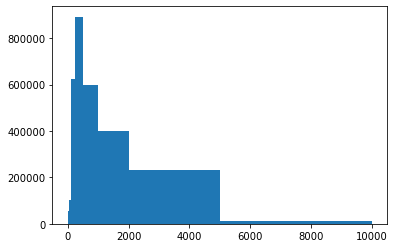

In [57]:
plt.hist(train['item_price'], bins=[0,50,100,250,500,1000,2000,5000,10000])

In [43]:
from datetime import datetime
train['year'] = pd.to_datetime(train['date']).dt.strftime('%Y')
train['month'] = train.date.apply(lambda x: datetime.strptime(x,'%d.%m.%Y').strftime('%m')) 

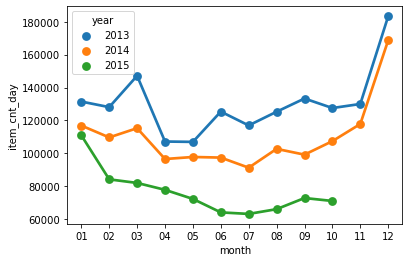

In [44]:
grouped = pd.DataFrame(train.groupby(['year','month'])['item_cnt_day'].sum().reset_index())
sns.pointplot(x='month', y='item_cnt_day', hue='year', data=grouped)

In [85]:
import os
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
#import cudf

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5);
sns.set_style('whitegrid')

In [91]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name"] = 'СергиевПосад ТЦ "7Я"'
shops.loc[shops.shop_name.str.contains(
    'Жуковский ул. Чкалова 39м', case=False),"shop_name"] = 'Жуковский ул. Чкалова 39м'
shops.loc[shops.shop_name.str.contains(
    'Якутск Орджоникидзе, 56', case=False),"shop_name"] = 'Якутск Орджоникидзе, 56'
shops.loc[shops.shop_name.str.contains(
    '!Якутск ТЦ "Центральный" фран', case=False),"shop_name"] = 'Якутск ТЦ "Центральный" фран'
shops["city"] = shops.shop_name.str.split(" ").map(lambda x: x[0])
shops["category"] = shops.shop_name.str.split(" ").map(lambda x: x[1])
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"

In [92]:
shops.category.value_counts()

ТЦ                28
ТРЦ               11
ТРК                5
ТК                 5
Орджоникидзе,      2
ул.                2
Магазин            1
"Распродажа"       1
МТРЦ               1
склад              1
Торговля           1
(Плехановская,     1
ЧС                 1
Name: category, dtype: int64

In [93]:
counts = shops['category'].value_counts()
idx = counts[counts.lt(4)].index

shops.loc[shops['category'].isin(idx), 'category'] = 'OTHER'
shops.loc[shops[shops.city=='СергиевПосад'].index, 'city'] = 'ТЦ'
shops.head()

,shop_name,shop_id,city,category
0,"Якутск Орджоникидзе, 56",0,Якутск,OTHER
1,"Якутск ТЦ ""Центральный"" фран",1,Якутск,ТЦ
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,ТРК
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,ТЦ


In [94]:
shops.city.unique()
shops.category.unique()

array(['Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'ТЦ',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Ярославль'], dtype=object)

array(['OTHER', 'ТЦ', 'ТРК', 'ТРЦ', 'ТК'], dtype=object)

In [95]:
set(train['item_id']) == set(test['item_id'])
set(train['shop_id']) == set(test['shop_id'])

False

False

In [96]:
train['item_in_test'] = train['item_id'].isin(list(test['item_id']))
train['shop_in_test'] = train['shop_id'].isin(list(test['shop_id']))

In [72]:
train.shape[0]

2935845

In [97]:
train['item_in_test'].sum()
train['shop_in_test'].sum()

1446006

2413246

In [98]:
items['item_name'].unique()

array(['! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D',
       '!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]',
       '***В ЛУЧАХ СЛАВЫ   (UNV)                    D', ...,
       'Язык запросов 1С:Предприятия 8 (+CD). Хрусталева Е.Ю.',
       'Яйцо для Little Inu', 'Яйцо дракона (Игра престолов)'],
      dtype=object)

In [117]:
def broad_category(string):
    if '-' in string:
        cat = string.split('-')[0].strip(' ')
    elif '(' in string:
        cat = string.split('(')[0].strip(' ')
    else:
        cat = string
    return cat

def narrow_category(string):
    if '-' in string:
        cat = string.split('-')[1].strip(' ')
    elif '(' in string:
        cat = string.split('(')[1].strip(' ').replace(')', '')
    else:
        cat = 'UNK'
    return cat

categories['super_cat'] = categories['item_category_name'].apply(broad_category)
categories['sub_cat'] = categories['item_category_name'].apply(narrow_category)

In [118]:
super_cat_dict = {x:y for x, y in zip(
    categories['super_cat'].unique(), range(1, categories['super_cat'].nunique()+1))}
sub_cat_dict = {x:y for x, y in zip(
    categories['sub_cat'].unique(), range(1, categories['sub_cat'].nunique()+1))}

super_cat_index = {y:x for x, y in super_cat_dict.items()}
sub_cat_index = {y:x for x, y in sub_cat_dict.items()}

In [119]:
cats_m = pd.merge(items, categories, on='item_category_id').drop('item_category_id', axis=1)
cats_m.head()

,item_name,item_id,item_category_name,super_cat,sub_cat
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,Кино - DVD,Кино,DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,Кино - DVD,Кино,DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,Кино - DVD,Кино,DVD
3,***КОРОБКА (СТЕКЛО) D,4,Кино - DVD,Кино,DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,Кино - DVD,Кино,DVD


In [120]:
items_train = pd.merge(cats_m, train, on='item_id')
items_test = pd.merge(cats_m, test, on='item_id').drop('item_category_name', axis=1)
items_train = pd.merge(items_train, shops, on='shop_id')
items_test = pd.merge(items_test, shops, on='shop_id')

assert items_train.shape[0]==train.shape[0]
assert items_test.shape[0]==test.shape[0]
items_train.head(3)
items_test.head(3)

,item_name,item_id,item_category_name,super_cat,sub_cat,date,date_block_num,shop_id,item_price,item_cnt_day,item_in_test,shop_in_test,shop_name,city,category
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,Кино - DVD,Кино,DVD,01.09.2014,20,54,58.0,1.0,False,False,"Химки ТЦ ""Мега""",Химки,ТЦ
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,Кино - DVD,Кино,DVD,24.08.2014,19,54,58.0,1.0,False,False,"Химки ТЦ ""Мега""",Химки,ТЦ
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,Кино - DVD,Кино,DVD,12.11.2014,22,54,58.0,1.0,False,False,"Химки ТЦ ""Мега""",Химки,ТЦ


,item_name,item_id,super_cat,sub_cat,ID,shop_id,shop_name,city,category
0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,30,Кино,DVD,2587,5,"Вологда ТРЦ ""Мармелад""",Вологда,ТРЦ
1,1+1,32,Кино,DVD,595,5,"Вологда ТРЦ ""Мармелад""",Вологда,ТРЦ
2,101 ДАЛМАТИНЕЦ 2 м/ф (регион),64,Кино,DVD,528,5,"Вологда ТРЦ ""Мармелад""",Вологда,ТРЦ


In [121]:
items_train.super_cat.unique()

array(['Кино', 'Музыка', 'Игры', 'Игры PC', 'Книги', 'Программы',
       'Подарки', 'Карты оплаты', 'Аксессуары', 'Игровые консоли',
       'Билеты', 'Чистые носители', 'Служебные', 'Элементы питания', 'PC',
       'Доставка товара', 'Игры MAC', 'Игры Android'], dtype=object)

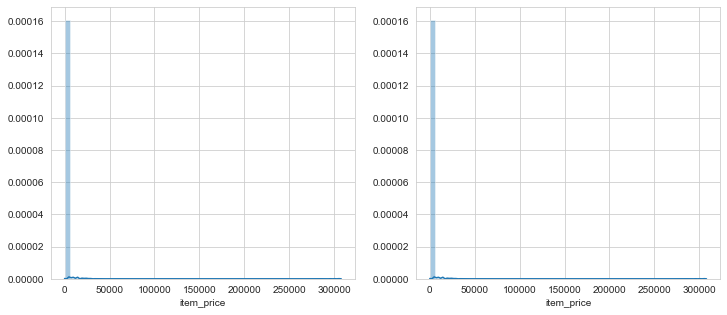

In [122]:
fig, ax = plt.subplots(1, 2)
sns.distplot(items_train['item_price'].dropna(), ax=ax[0]);
sns.distplot(items_train['item_price'].fillna(items_train['item_price'].median()), ax=ax[1]);

C:\Users\AYSE\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\AYSE\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


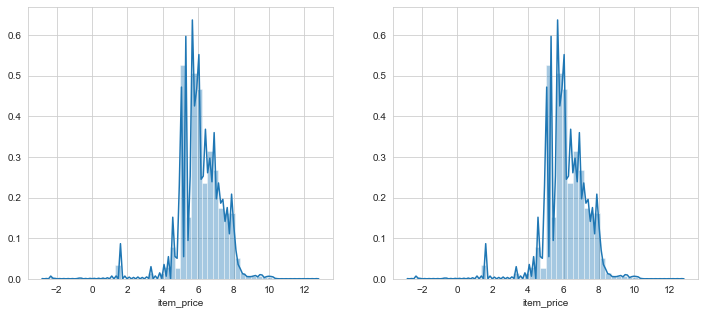

In [123]:
fig, ax = plt.subplots(1, 2)
sns.distplot(np.log(items_train['item_price'].dropna()), ax=ax[0]);
sns.distplot(np.log(items_train['item_price'].fillna(items_train['item_price'].median())), ax=ax[1]);

In [124]:
to_drop = ['item_name', 'date', 
           'shop_name', 'item_category_name']
items_train = items_train.drop(to_drop, axis=1)

In [125]:
grouped = items_train.groupby(['item_id', 'shop_id', 'date_block_num'], as_index=False)

In [ ]:
items_train = grouped.agg({'super_cat': encode_super_cats, 
             'sub_cat': encode_sub_cats, 
             'item_price': mean_log, 
             'item_cnt_day': np.sum,
            'item_in_test': to_int,
            'shop_in_test': to_int})

items_train.head()

In [ ]:
X = items_train.drop(['item_cnt_day', 
                      'date_block_num', 
                      'item_id', 
                      'item_in_test', 
                      'shop_in_test',
                     'item_price'], axis=1) 
#[['super_cat', 'sub_cat']]
y = items_train.item_cnt_day
X
y

In [130]:
kf = KFold(n_splits=5)
model = CatBoostRegressor(cat_features=['shop_id', 'super_cat', 'sub_cat'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = model.fit(X_train, y_train)
preds = model.predict(X_test)
print('rmse:', mean_squared_error(y_test, preds, squared=False))

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=3]="Москва": Cannot convert 'b'\xd0\x9c\xd0\xbe\xd1\x81\xd0\xba\xd0\xb2\xd0\xb0'' to float